In [104]:
import cv2
import fitz
import matplotlib.pyplot as plt
import numpy as np
import scipy
from math import sin, cos

In [105]:
slate_path = "./data/Dive Slate#1.pdf"
img_path = "./data/P8290016.PNG"

In [106]:
doc = fitz.open(slate_path)
page = doc.load_page(0)
pix = page.get_pixmap()

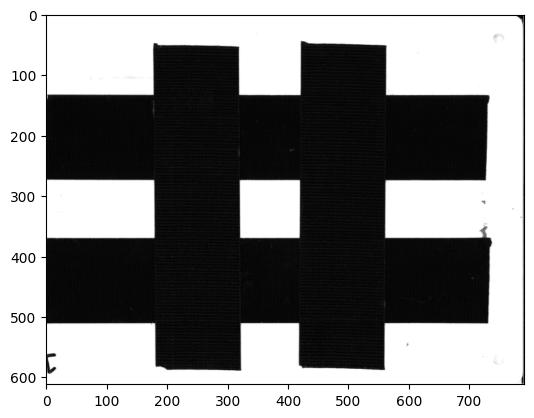

In [107]:
slate_img = cv2.cvtColor(np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, 3)), cv2.IMREAD_GRAYSCALE)[:, :, 0]

plt.imshow(slate_img, cmap="gray")

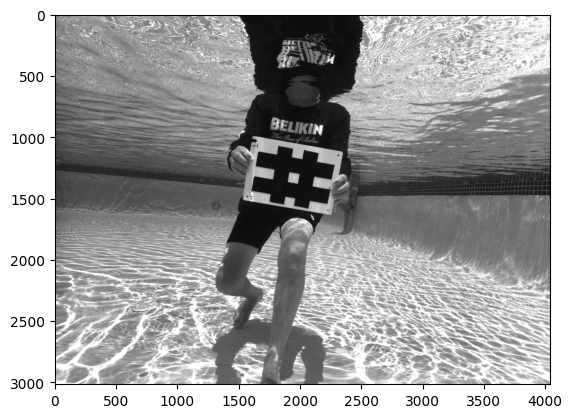

In [108]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")

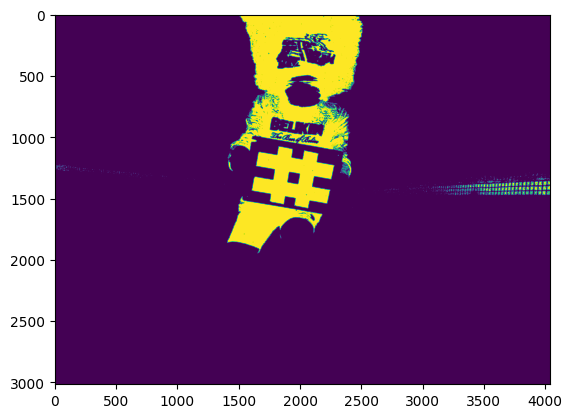

In [109]:
ret, thresholded = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)

plt.imshow(thresholded)

In [110]:
# get the largest contour from the original slate pdf
ret2, slate_threshold = cv2.threshold(slate_img, 100, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(slate_threshold, cv2.MORPH_OPEN, kernel)
slate_contours, slate_hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
slate_contour = None
for c in slate_contours:
    area = cv2.contourArea(c)
    if area > max_area:
        max_area = area
        slate_contour = c

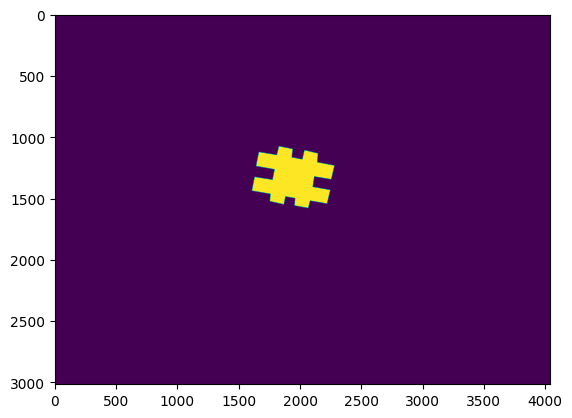

In [111]:
# get the matching contour in the calibration image
test_contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_score = np.inf
slate_in_image = None
for t in test_contours: 
    score = cv2.matchShapes(t, slate_contour, cv2.CONTOURS_MATCH_I2, 0.0)
    if score < min_score: 
        min_score = score
        slate_in_image = t

img_contour: np.ndarray = cv2.approxPolyDP(slate_in_image, 10, closed=True)
display = cv2.drawContours(np.zeros(img.shape), [img_contour], 0, 255, cv2.FILLED, 8)
plt.imshow(display)

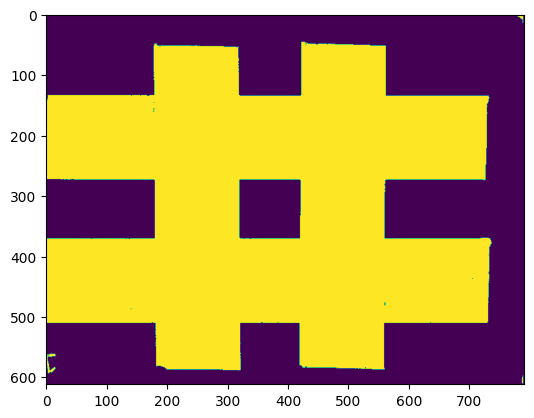

In [112]:
ret, pdf_threshold = cv2.threshold(slate_img, 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(pdf_threshold)

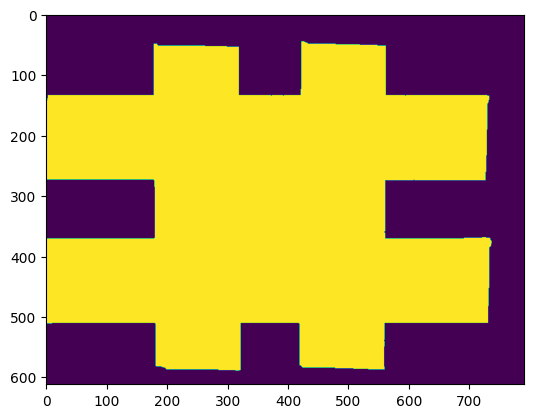

In [113]:
pdf_display = cv2.drawContours(np.zeros(pdf_threshold.shape), [slate_contour], 0, 255, cv2.FILLED, 8)
plt.imshow(pdf_display)

In [114]:
def error(img_contour: np.ndarray, slate_contour: np.ndarray):
    return scipy.spatial.distance.cdist(slate_contour.astype(float), img_contour.astype(float)).min(axis=1).mean() ** 2

def homo2contour(homogeneous_coords: np.ndarray):
    return np.round(homogeneous_coords[:, :2]).astype(int)

In [115]:
def calculate_transform(img_contour: np.ndarray, slate_contour: np.ndarray, angle: float):
    T = np.array([[cos(angle), -sin(angle), 0],
                  [sin(angle), cos(angle), 0],
                  [0, 0, 1]], dtype=float)
    
    slate_height, _, _ = slate_contour.shape
    slate_contour_homo = np.ones((slate_height, 3), dtype=float)
    slate_contour_homo[:, :2] = slate_contour.squeeze(1)

    transformed_slate_contour = (T @ slate_contour_homo.T).T

    img_radius = np.sqrt(cv2.contourArea(img_contour) / np.pi)
    slate_radius = np.sqrt(cv2.contourArea(homo2contour(transformed_slate_contour)) / np.pi)

    scale = img_radius / slate_radius

    T *= scale
    T[2, 2] = 1

    transformed_slate_contour = (T @ slate_contour_homo.T).T

    img_M = cv2.moments(img_contour)
    img_cx = int(img_M['m10']/img_M['m00'])
    img_cy = int(img_M['m01']/img_M['m00'])
    img_center = np.array([[img_cx], [img_cy]])

    slate_M = cv2.moments(homo2contour(transformed_slate_contour))
    slate_cx = int(slate_M['m10']/slate_M['m00'])
    slate_cy = int(slate_M['m01']/slate_M['m00'])
    slate_center = np.array([[slate_cx], [slate_cy]])

    T[:2, 2] = (img_center - slate_center).squeeze()

    return T

In [116]:
slate_height, _, _ = slate_contour.shape
slate_contour_homo = np.ones((slate_height, 3), dtype=float)
slate_contour_homo[:, :2] = slate_contour.squeeze(1)

In [117]:
_, _, img_angle = cv2.fitEllipse(img_contour)
_, _, slate_angle = cv2.fitEllipse(slate_contour)

angle_difference_one = (img_angle - slate_angle) * np.pi / 180.0

In [118]:
T_one = calculate_transform(img_contour, slate_contour, angle_difference_one)
T_two = calculate_transform(img_contour, slate_contour, np.pi + angle_difference_one)

In [119]:
transformed_slate_contour_one = (T_one @ slate_contour_homo.T).T
transformed_slate_contour_two = (T_two @ slate_contour_homo.T).T

In [120]:
error_one = error(img_contour.squeeze(1), homo2contour(transformed_slate_contour_one))
error_two = error(img_contour.squeeze(1), homo2contour(transformed_slate_contour_two))

error_one, error_two

(304.3436043035956, 374.30959695763386)

In [121]:
transformed_slate_contour = transformed_slate_contour_one if error_one < error_two else transformed_slate_contour_two
T = T_one if error_one < error_two else T_two


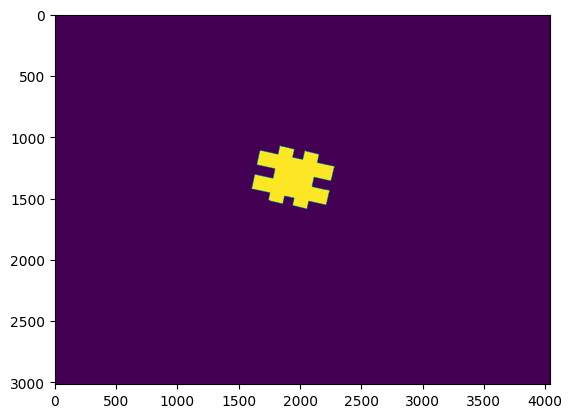

In [122]:
pdf_display = cv2.drawContours(np.zeros(img.shape), [homo2contour(transformed_slate_contour)], 0, 255, cv2.FILLED, 8)
plt.imshow(pdf_display)

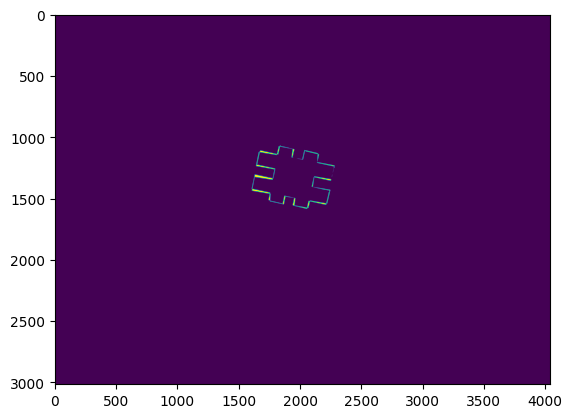

In [123]:
plt.imshow(np.abs(pdf_display - display))

In [133]:
corners = scipy.spatial.distance.cdist(homo2contour(transformed_slate_contour).astype(float), img_contour.squeeze(1).astype(float), 'euclidean').argmin(axis=1)
corners.shape

(145,)

In [132]:
homo2contour(transformed_slate_contour).astype(float).shape

(145, 2)